# Hotel Booking Analysis (A–G)

This notebook is organized into sections **Part A → Part G**.

## Contents
- **Part A**: Data loading + preprocessing
- **Part B**: Exploratory data analysis (EDA)
- **Part C**: Data balance checking + class balancing
- **Part D**: Feature engineering
- **Part E**: Feature selection (Genetic Algorithm)
- **Part F**: Model evaluation
- **Part G**: Final notes

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


## Part A — Data Loading & Preprocessing

In [5]:
# STEP 1: LOAD DATA
print("Loading Data")
print("-" * 70)

df = pd.read_csv("hotel_bookings.csv")

print(f"✓ Data loaded successfully")
print(f"  - Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n  - First few columns: {list(df.columns[:5])}")
print(f"  - Last few columns: {list(df.columns[-3:])}")

# STEP 2: INITIAL DATA INSPECTION
print("Initial Data Inspection")
print("-" * 70)

print(f"\nData types:")
print(df.dtypes.value_counts())

print(f"\nInitial missing values:")
missing_initial = df.isnull().sum()
print(missing_initial[missing_initial > 0])


Loading Data
----------------------------------------------------------------------
✓ Data loaded successfully
  - Shape: 119390 rows × 33 columns

  - First few columns: ['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month']
  - Last few columns: ['reservation_status', 'reservation_status_date', 'city']
Initial Data Inspection
----------------------------------------------------------------------

Data types:
int64      16
object     13
float64     4
Name: count, dtype: int64

Initial missing values:
children         4
country        488
agent        16340
company     112593
dtype: int64


In [6]:


# STEP 1: HANDLE MISSING VALUES
print("Handling Missing Values")
print("-" * 70)

# Check for missing values in each column
missing_counts = df.isnull().sum()
missing_columns = missing_counts[missing_counts > 0]

if len(missing_columns) > 0:
    print(f"Columns with missing values:")
    for col, count in missing_columns.items():
        percentage = (count / len(df)) * 100
        print(f"  • {col}: {count} ({percentage:.2f}%)")
    
    # Strategy for handling missing values:
    # Numerical columns: Fill with median or 0 (depending on context)
    # Categorical columns: Fill with mode or 'Unknown'
    
    if 'children' in df.columns and df['children'].isnull().sum() > 0:
        df['children'] = df['children'].fillna(0)
        print(f"\n✓ Filled 'children' with 0")
    
    if 'country' in df.columns and df['country'].isnull().sum() > 0:
        df['country'] = df['country'].fillna(df['country'].mode()[0])
        print(f"✓ Filled 'country' with mode: {df['country'].mode()[0]}") #Most common value
    
    if 'agent' in df.columns and df['agent'].isnull().sum() > 0:
        df['agent'] = df['agent'].fillna(-1)  # -1 indicates no agent
        print(f"✓ Filled 'agent' with -1 (no agent)")
    
    if 'company' in df.columns and df['company'].isnull().sum() > 0:
        df['company'] = df['company'].fillna(-1)  # -1 indicates no company
        print(f"✓ Filled 'company' with -1 (no company)")
    
    # Check for any remaining missing values
    remaining_missing = df.isnull().sum().sum()
    print(f"\n  Total missing values remaining: {remaining_missing}")
else:
    print("✓ No missing values found!")






# STEP 2: Fix data type of reservation_Status_date
print("Fixing 'reservation_status_date' as Time")
print("-" * 70)

if 'reservation_status_date' in df.columns:
    print(f"Original dtype: {df['reservation_status_date'].dtype}")
    print(f"Sample values before conversion:\n{df['reservation_status_date'].head(3)}")
    
    # Convert string times to datetime.time
    df['reservation_status_date'] = pd.to_datetime(
        df['reservation_status_date'],
        format='%I:%M:%S %p',  # matches example like "12:16:41 AM"
        errors='coerce'
    ).dt.time
    
    # Convert time to integer (seconds since midnight)
    df['reservation_time_seconds'] = df['reservation_status_date'].apply(
        lambda t: t.hour * 3600 + t.minute * 60 + t.second
    )
    
    print("✓ Converted 'reservation_status_date' to seconds past midnight (integer)")
    print(f"Sample values:\n{df[['reservation_status_date', 'reservation_time_seconds']].head(5)}")
    
    # Drop the original column 
    df = df.drop('reservation_status_date', axis=1)


# STEP 3: REMOVE DUPLICATES
print("Removing Duplicates")
print("-" * 70)

duplicates_count = df.duplicated().sum()
if duplicates_count > 0:
    print(f"Found {duplicates_count} duplicate rows")
    df = df.drop_duplicates()
    print(f"✓ Removed {duplicates_count} duplicates")
else:
    print("✓ No duplicates found")

print(f"  - Current shape: {df.shape}")


# STEP 4: HANDLE OUTLIERS (IQR METHOD)
print("Handling Outliers (IQR Method)")
print("-" * 70)

def remove_outliers_iqr(data, column):
    """
    Remove outliers from a specific column using IQR method.
    IQR (Interquartile Range) = Q3 - Q1
    Outliers are values < Q1 - 1.5*IQR or > Q3 + 1.5*IQR
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before removal
    outliers_count = ((data[column] < lower_bound) | (data[column] > upper_bound)).sum()
    
    # Filter data
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    return filtered_data, outliers_count, lower_bound, upper_bound

# Apply outlier removal to key numerical columns
outlier_columns = ['lead_time', 'adr']
initial_rows = len(df)

for col in outlier_columns:
    if col in df.columns:
        before_count = len(df)
        df, outliers_removed, lower, upper = remove_outliers_iqr(df, col)
        after_count = len(df)
        
        print(f"\n  Column: '{col}'")
        print(f"    - Outliers removed: {outliers_removed}")
        print(f"    - Bounds: [{lower:.2f}, {upper:.2f}]")
        print(f"    - Rows remaining: {after_count}")

total_outliers_removed = initial_rows - len(df)
print(f"\n✓ Total rows removed due to outliers: {total_outliers_removed}")
print(f"  - Final shape: {df.shape}")



# STEP 5: SAVE COPY FOR EDA (BEFORE ENCODING)
print("Saving Copy for EDA")
print("-" * 70)

# Save a copy with original categorical values for visualization
df_eda = df.copy()
print("✓ Created 'df_eda' - copy with original categorical values for EDA")


print("✓ Dropped 'reservation_status_date' from main dataframe (features extracted)")


# STEP 6: ENCODE CATEGORICAL VARIABLES
print("Encoding Categorical Variables")
print("-" * 70)

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns found: {len(categorical_cols)}")
print(f"  {categorical_cols[:5]}... (showing first 5)")

# Apply Label Encoding to specific columns (ordinal or low cardinality)
label_encode_cols = ['hotel', 'deposit_type', 'customer_type']
label_encoders = {}

print(f"Applying Label Encoding to: {label_encode_cols}")
for col in label_encode_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        print(f"  ✓ {col}: {len(le.classes_)} unique values → [0-{len(le.classes_)-1}]")

# Apply One-Hot Encoding to remaining categorical columns
print(f"Applying One-Hot Encoding to remaining categorical columns")
df = pd.get_dummies(df, drop_first=True)  # drop_first=True to avoid multicollinearity
print(f"  One-Hot Encoding applied")
print(f"  New shape: {df.shape}")




#DATE FEATURE EXTRACTION
month_available = False

if 'arrival_date_month' in df.columns:
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    df['arrival_date_month_num'] = df['arrival_date_month'].map(month_map)
    month_available = True
    print("✓ arrival_date_month mapped to numeric")

elif 'arrival_date_month_num' in df.columns:
    month_available = True
    print("✓ arrival_date_month_num already exists")

else:
    print("arrival month info not available — skipping month-based features")


# Build arrival_date only if all components exist
date_cols = ['arrival_date_year', 'arrival_date_month_num', 'arrival_date_day_of_month']

if month_available and all(col in df.columns for col in date_cols):
    df['arrival_date'] = pd.to_datetime(df[date_cols], errors='coerce')

    df['arrival_weekday'] = df['arrival_date'].dt.weekday
    df['arrival_week'] = df['arrival_date'].dt.isocalendar().week.astype(int)
    df['arrival_season'] = df['arrival_date_month_num'] % 12 // 3 + 1

    print("✓ Date-based features created")
else:
    print("Skipping arrival_date feature creation")






# STEP 7: FINAL VERIFICATION
print("\n" + "=" * 70)
print("FINAL DATA PREPROCESSING SUMMARY")
print("=" * 70)

print(f"Dataset Information:")
print(f"  - Final shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"  - Missing values: {df.isnull().sum().sum()}")
print(f"  - Duplicates: {df.duplicated().sum()}")
print(f"  - Data types: {df.dtypes.value_counts().to_dict()}")

print(f"Target variable (is_canceled):")
if 'is_canceled' in df.columns:
    print(df['is_canceled'].value_counts())
    print(f"  - Class balance: {df['is_canceled'].value_counts(normalize=True).to_dict()}")

print(f"\n🎯 Key Numerical Features (first 5):")
numeric_features = df.select_dtypes(include=[np.number]).columns[:5].tolist()
print(f"  {numeric_features}")

print("\n" + "=" * 70)
print("PART A COMPLETED SUCCESSFULLY!")
print("=" * 70)
print("Variables created:")
print("  - df: Preprocessed dataset (encoded, ready for modeling)")
print("  - df_eda: Copy with original values (ready for visualization)")
print("  - label_encoders: Dictionary of label encoders for reference")

Handling Missing Values
----------------------------------------------------------------------
Columns with missing values:
  • children: 4 (0.00%)
  • country: 488 (0.41%)
  • agent: 16340 (13.69%)
  • company: 112593 (94.31%)

✓ Filled 'children' with 0
✓ Filled 'country' with mode: PRT
✓ Filled 'agent' with -1 (no agent)
✓ Filled 'company' with -1 (no company)

  Total missing values remaining: 0
Fixing 'reservation_status_date' as Time
----------------------------------------------------------------------
Original dtype: object
Sample values before conversion:
0    12:16:41 AM
1    12:56:22 AM
2    12:46:26 AM
Name: reservation_status_date, dtype: object
✓ Converted 'reservation_status_date' to seconds past midnight (integer)
Sample values:
  reservation_status_date  reservation_time_seconds
0                00:16:41                      1001
1                00:56:22                      3382
2                00:46:26                      2786
3                00:07:10            

## Part B — Exploratory Data Analysis (EDA)

DISTRIBUTION OF CANCELLATIONS
----------------------------------------------------------------------
Total Bookings: 112,617
Not Canceled: 71,861 (63.8%)
Canceled: 40,756 (36.2%)


<>:75: SyntaxWarning: invalid escape sequence '\I'
<>:225: SyntaxWarning: invalid escape sequence '\I'
<>:75: SyntaxWarning: invalid escape sequence '\I'
<>:225: SyntaxWarning: invalid escape sequence '\I'
/var/folders/_w/kvlqpzmn4cqdnqkjzshfr4y80000gn/T/ipykernel_13325/727808564.py:75: SyntaxWarning: invalid escape sequence '\I'
  print(f"\INSIGHT:")
/var/folders/_w/kvlqpzmn4cqdnqkjzshfr4y80000gn/T/ipykernel_13325/727808564.py:225: SyntaxWarning: invalid escape sequence '\I'
  print(f"\INSIGHT:")


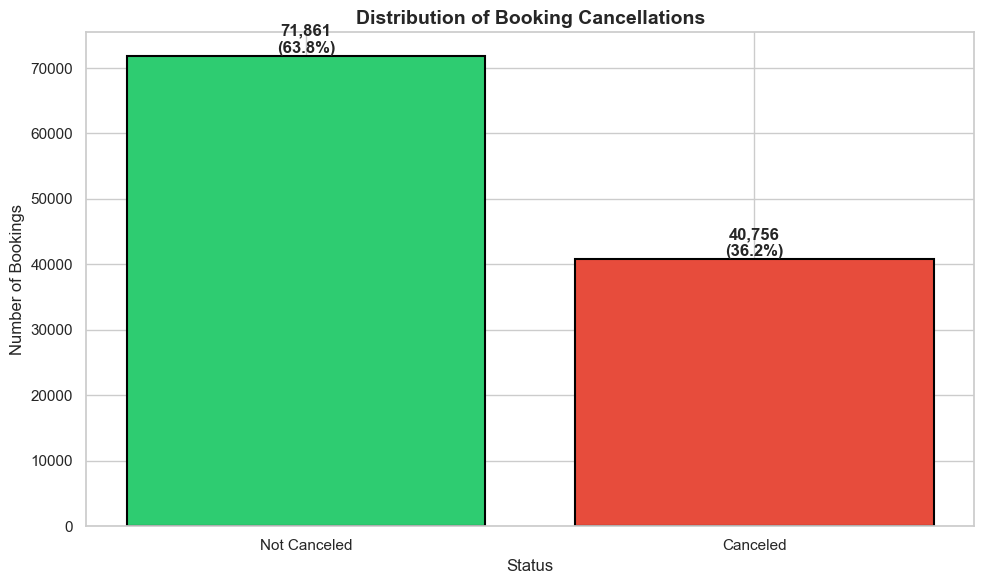

INSIGHT:
   - 36.2% cancellation rate indicates MODERATE business risk
   - Approximately 1 in every 2.8 bookings gets canceled
   - This imbalance (64/36) will require balancing for ML models

BOOKING TRENDS BY MONTH
----------------------------------------------------------------------
Peak Month: October (9,750 bookings)
Lowest Month: February (9,048 bookings)


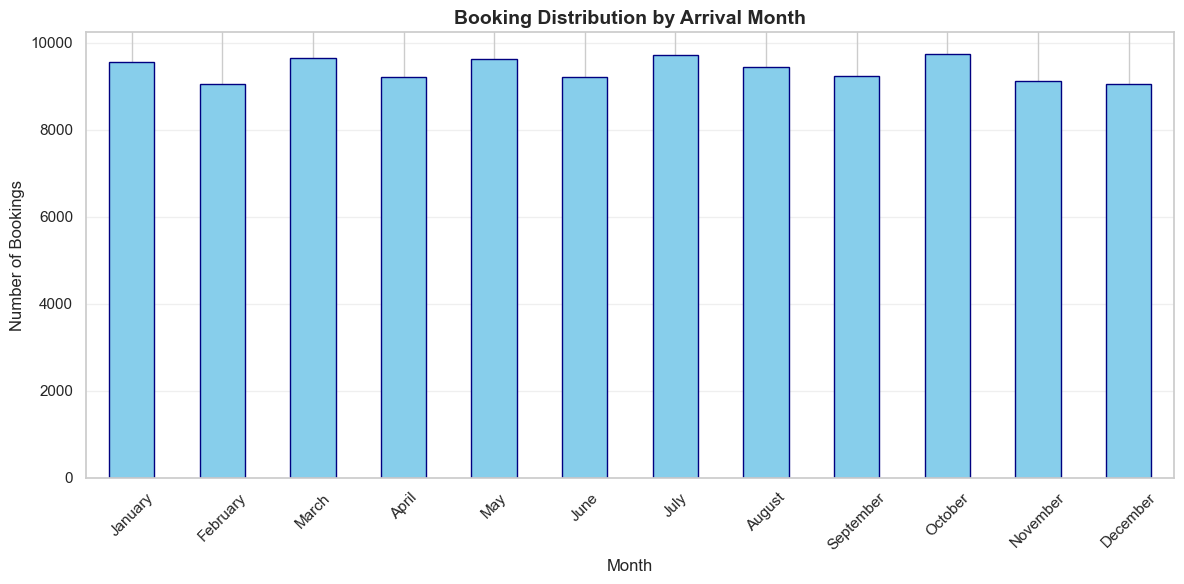

\INSIGHT:
   - Clear SEASONALITY pattern: October has 1.1x more bookings than February
   - Summer months (June-August) show highest demand
   - Hotels should adjust pricing and staffing based on seasonal patterns

BOOKING TRENDS BY WEEK
----------------------------------------------------------------------
Using column: 'arrival_date_week_number'
Week with most bookings: Week 1 (2,445 bookings)
Week with least bookings: Week 50 (2,084 bookings)


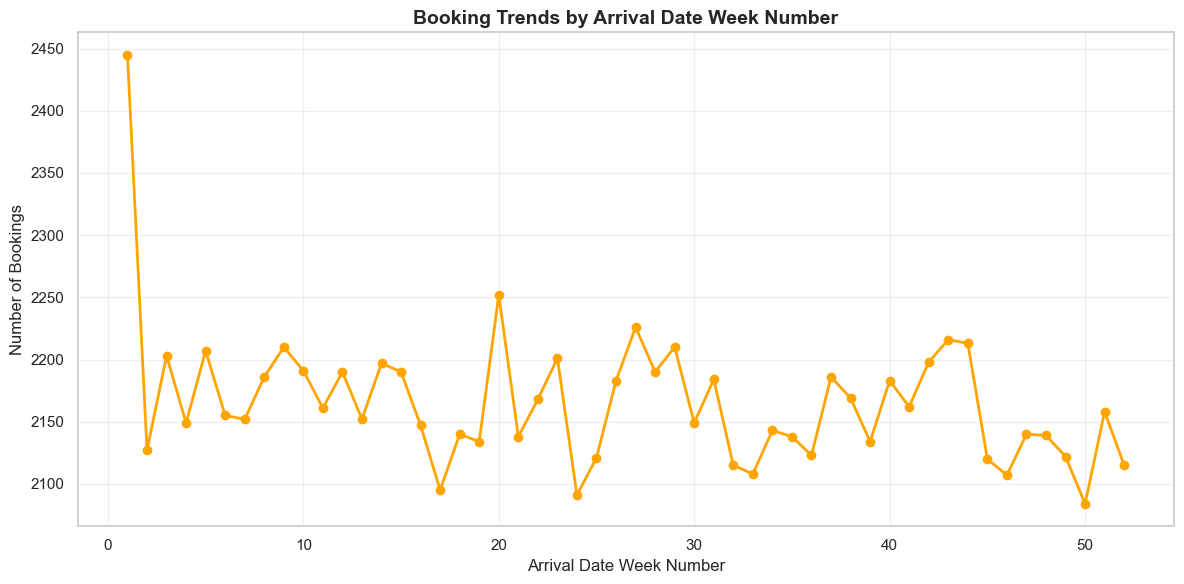

/var/folders/_w/kvlqpzmn4cqdnqkjzshfr4y80000gn/T/ipykernel_13325/727808564.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.values, y=city_counts.index, palette='viridis')


INSIGHT:
   - Weekly booking patterns show variation with specific peaks
   - Understanding weekly trends helps optimize operational capacity

BOOKING TRENDS BY CITY (TOP 10)
----------------------------------------------------------------------
Top City: Bhopal (7,632 bookings, 6.8% of total)
Top 10 cities account for: 75,432 bookings (67.0%)


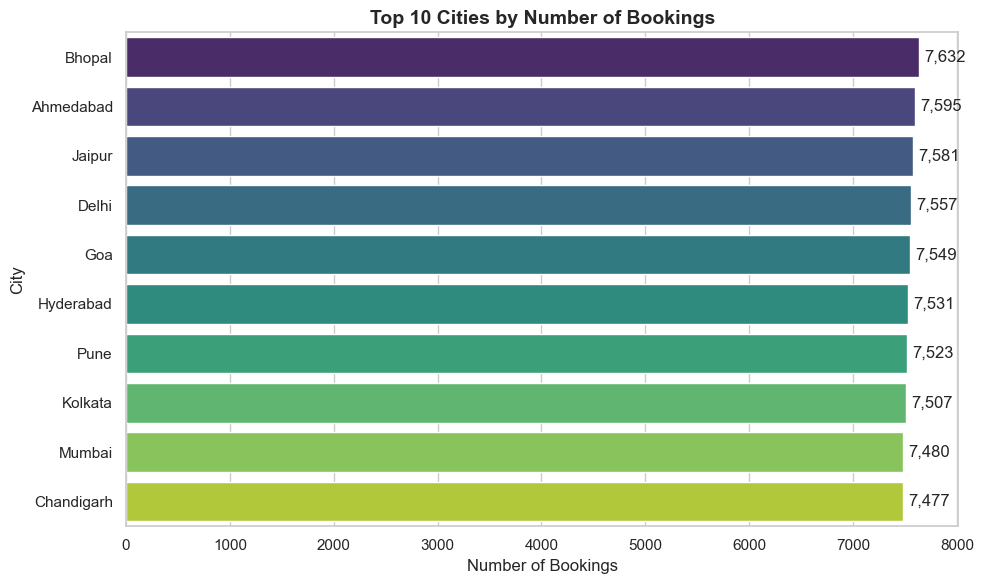

INSIGHT:
   - GEOGRAPHIC CONCENTRATION: Top 10 cities represent 67.0% of bookings
   - Bhopal dominates with 6.8% market share
   - Hotels should focus marketing efforts on these key cities

RELATIONSHIP BETWEEN ADR AND CANCELLATIONS
----------------------------------------------------------------------
Average ADR (Not Canceled): $95.28
Average ADR (Canceled): $101.57
Difference: $6.29 (+6.6%)


/var/folders/_w/kvlqpzmn4cqdnqkjzshfr4y80000gn/T/ipykernel_13325/727808564.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eda, x='is_canceled', y='adr', palette=['#2ecc71', '#e74c3c'])


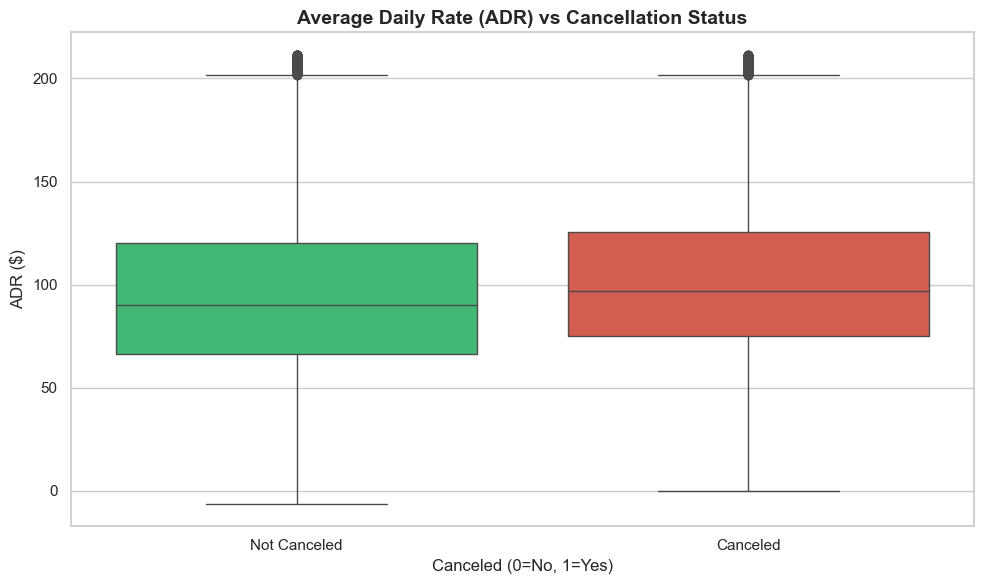

INSIGHT:
   - Canceled bookings have HIGHER ADR ($6.29 more on average)
   - Suggests PRICE SENSITIVITY: customers cancel expensive bookings more often
   - Consider flexible cancellation policies for higher-priced rooms

CORRELATION HEATMAP (FOCUSED ON KEY FEATURES)
----------------------------------------------------------------------


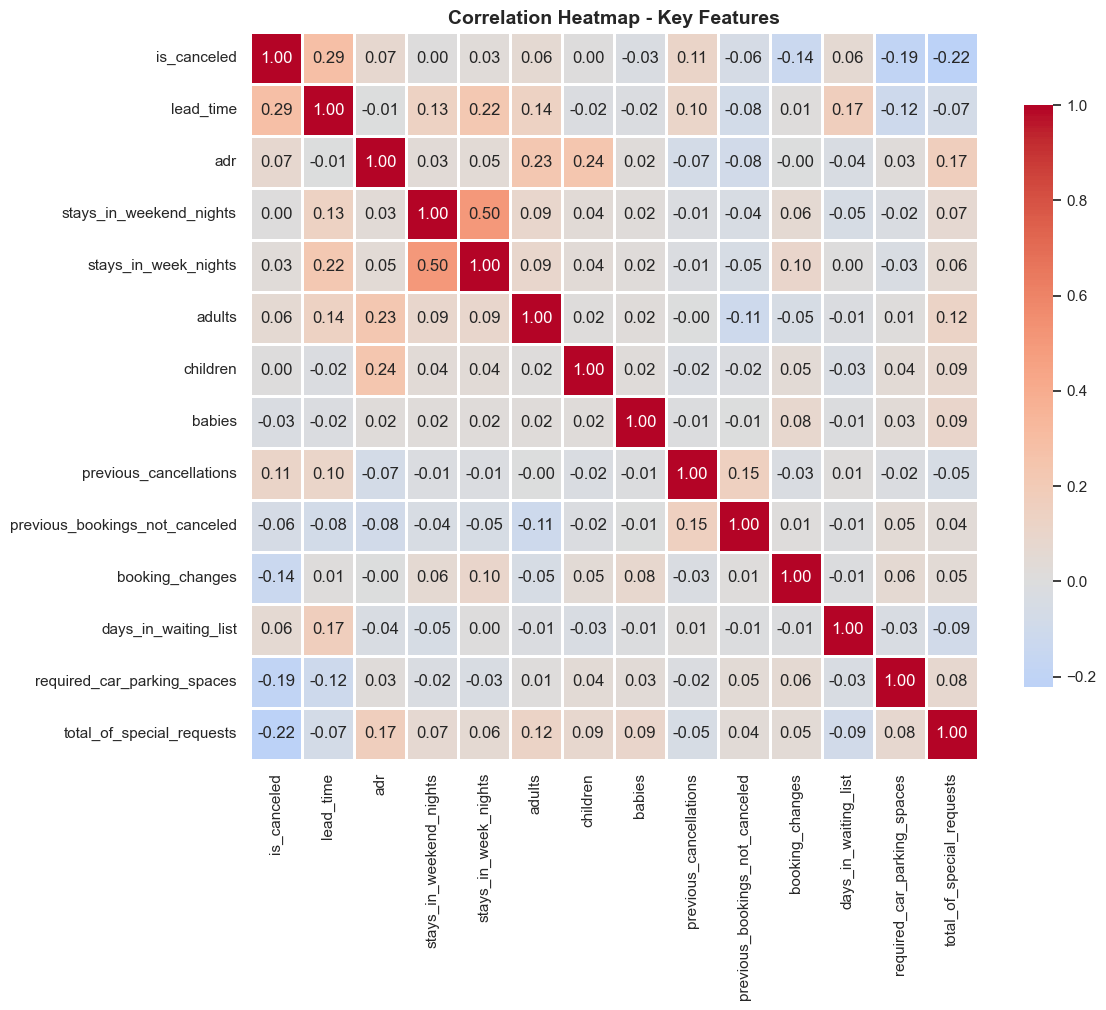


Top Correlations with 'is_canceled':
is_canceled                1.000000
lead_time                  0.288038
previous_cancellations     0.113101
adr                        0.073889
adults                     0.060348
days_in_waiting_list       0.057564
stays_in_week_nights       0.028000
stays_in_weekend_nights    0.004438
Name: is_canceled, dtype: float64
INSIGHT:
   - STRONGEST PREDICTOR: lead_time (correlation: 0.288)
   - Lead time shows positive correlation → longer advance bookings = higher cancellation
   - Previous cancellations indicate customer behavior patterns
   - These features will be crucial for prediction models

LEAD TIME ANALYSIS
----------------------------------------------------------------------
Lead Time Statistics:
  Mean: 96.0 days
  Median: 67.0 days
  Min: 0 days
  Max: 373 days
  75th percentile: 153 days


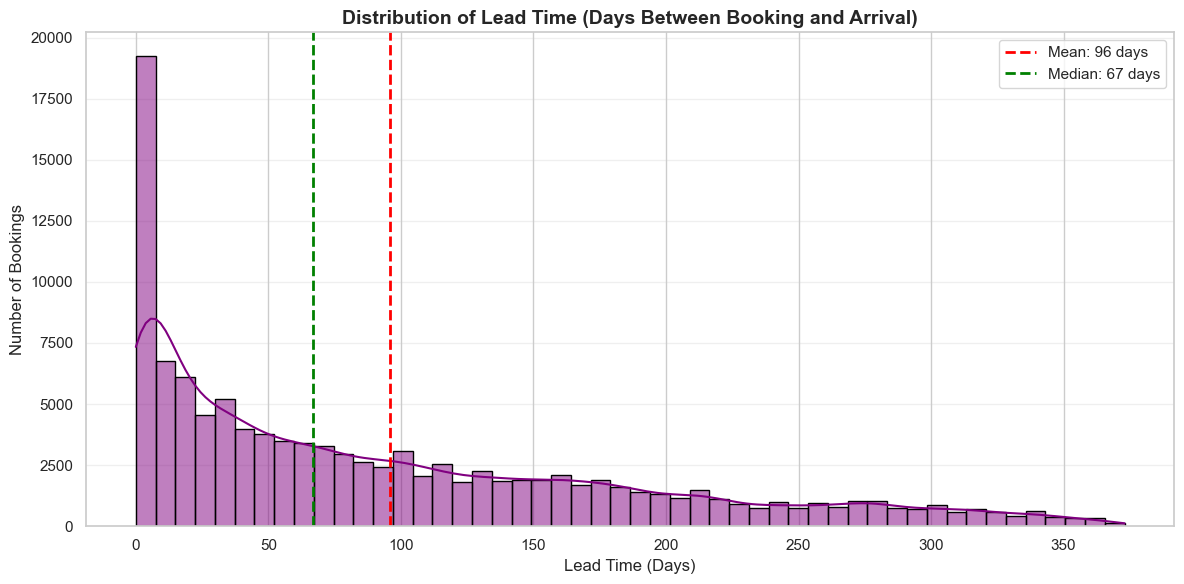

\INSIGHT:
   - Most bookings occur 67 days in advance (median)
   - Right-skewed distribution: few customers book very far ahead
   - 75% of bookings made within 153 days

CATEGORICAL ANALYSIS (WITH CANCELLATION RATES)
----------------------------------------------------------------------
Hotel Type Analysis:
                           Total_Bookings  Canceled  Cancel_Rate
hotel                                                           
City Hotel - Ahmedabad               5159      2135        0.414
City Hotel - Bangalore               4957      2096        0.423
City Hotel - Bhopal                  5115      2032        0.397
City Hotel - Chandigarh              4993      2020        0.405
City Hotel - Chennai                 4984      2024        0.406
City Hotel - Delhi                   5022      2041        0.406
City Hotel - Goa                     5043      2047        0.406
City Hotel - Hyderabad               5078      2103        0.414
City Hotel - Indore                  49

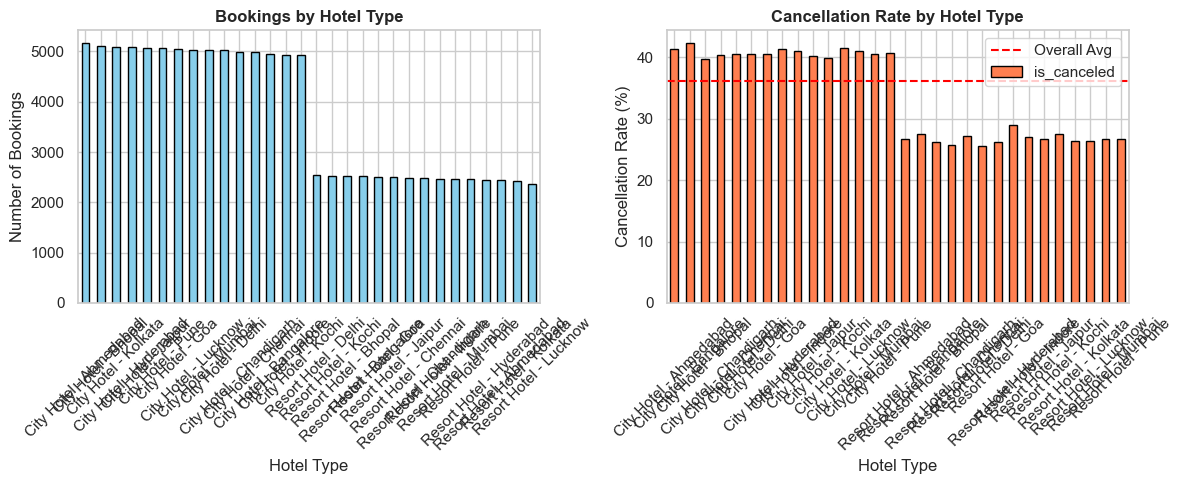

INSIGHT: Different hotel types show varying cancellation behaviors
Market Segment Analysis:
                Total_Bookings  Canceled  Cancel_Rate
market_segment                                       
Online TA                53792     19505        0.363
Offline TA/TO            23146      7910        0.342
Groups                   17690     10448        0.591
Direct                   11719      1752        0.150
Corporate                 5289       990        0.187
Complementary              742        97        0.131
Aviation                   237        52        0.219
Undefined                    2         2        1.000


/var/folders/_w/kvlqpzmn4cqdnqkjzshfr4y80000gn/T/ipykernel_13325/727808564.py:277: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_segments.values, y=top_segments.index, palette='viridis')
/var/folders/_w/kvlqpzmn4cqdnqkjzshfr4y80000gn/T/ipykernel_13325/727808564.py:283: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancel_by_segment.values, y=cancel_by_segment.index, palette='rocket')


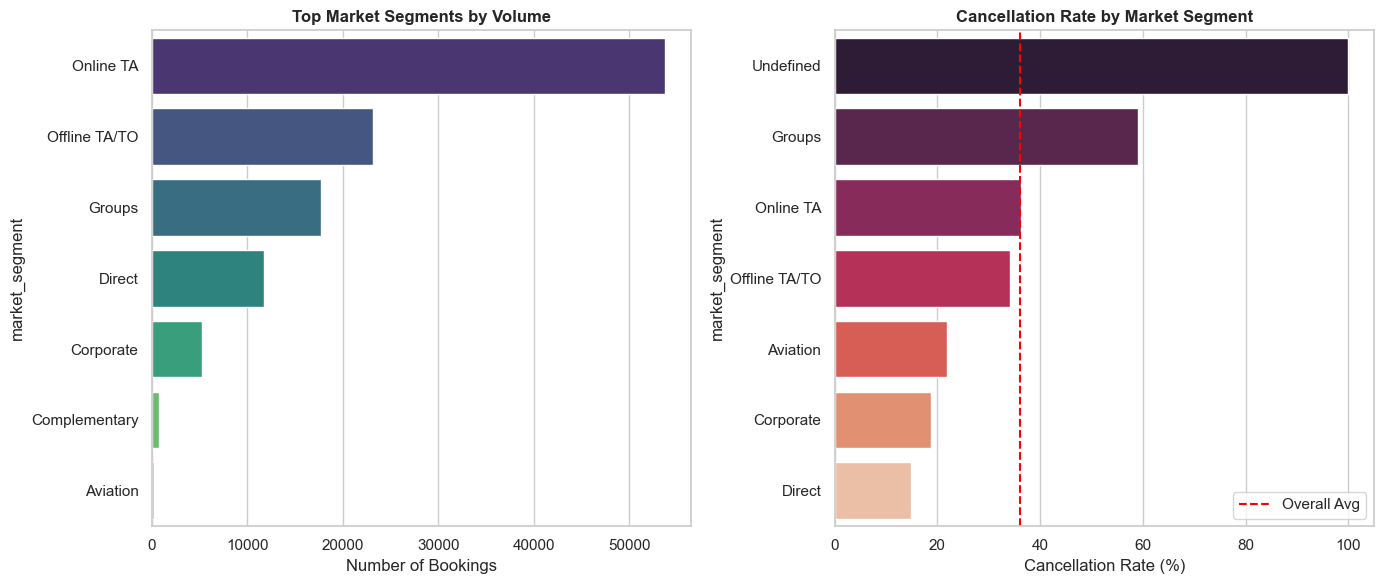

INSIGHT: 'Undefined' segment has highest cancellation rate (100.0%)
Customer Type Analysis:
                 Total_Bookings  Canceled  Cancel_Rate
customer_type                                         
Contract                   3983      1209        0.304
Group                       563        54        0.096
Transient                 84430     33371        0.395
Transient-Party           23641      6122        0.259


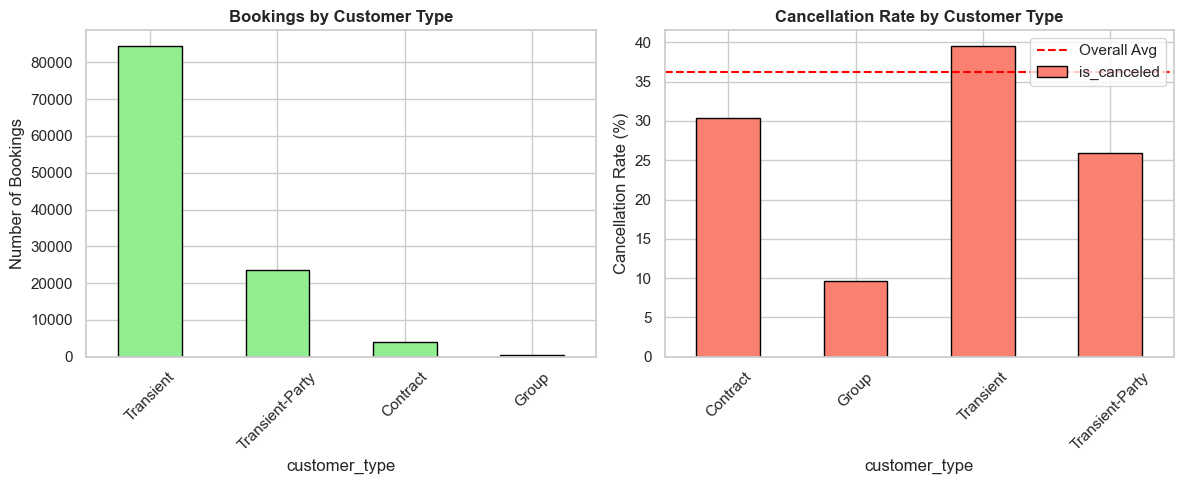

INSIGHT: 'Transient' customers have highest cancellation rate (39.5%)

PART B: EDA COMPLETED SUCCESSFULLY!
Key Findings Summary:
   1. Cancellation rate: 36.2% - requires class balancing
   2. Strong seasonality: October peak, February low
   3. Lead time is strongest predictor of cancellations
   4. Geographic concentration in top 10 cities
   5. Higher ADR associated with more cancellations
   6. Customer type and market segment show significant variation



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# 1DISTRIBUTION OF CANCELLATIONS
print("DISTRIBUTION OF CANCELLATIONS")
print("-" * 70)

# Calculate statistics
total_bookings = len(df_eda)
canceled_bookings = df_eda['is_canceled'].sum()
not_canceled = total_bookings - canceled_bookings
cancel_rate = (canceled_bookings / total_bookings) * 100

print(f"Total Bookings: {total_bookings:,}")
print(f"Not Canceled: {not_canceled:,} ({100-cancel_rate:.1f}%)")
print(f"Canceled: {canceled_bookings:,} ({cancel_rate:.1f}%)")

# Visualization
plt.figure(figsize=(10, 6))
counts = df_eda['is_canceled'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = plt.bar(['Not Canceled', 'Canceled'], counts.values, color=colors, edgecolor='black', linewidth=1.5)
plt.title('Distribution of Booking Cancellations', fontsize=14, fontweight='bold')
plt.ylabel('Number of Bookings', fontsize=12)
plt.xlabel('Status', fontsize=12)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/total_bookings*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

ratio = total_bookings / canceled_bookings
print(f"INSIGHT:")
print(f"   - {cancel_rate:.1f}% cancellation rate indicates MODERATE business risk")
print(f"   - Approximately 1 in every {ratio:.1f} bookings gets canceled")
print(f"   - This imbalance ({100-cancel_rate:.0f}/{cancel_rate:.0f}) will require balancing for ML models\n")

# BOOKING TRENDS BY MONTH
print("BOOKING TRENDS BY MONTH")
print("-" * 70)

# Set month order
df_eda['arrival_date_month'] = pd.Categorical(
    df_eda['arrival_date_month'], 
    categories=['January','February','March','April','May','June',
                'July','August','September','October','November','December'], 
    ordered=True
)

monthly_bookings = df_eda.groupby('arrival_date_month', observed=True).size()
peak_month = monthly_bookings.idxmax()
low_month = monthly_bookings.idxmin()

print(f"Peak Month: {peak_month} ({monthly_bookings.max():,} bookings)")
print(f"Lowest Month: {low_month} ({monthly_bookings.min():,} bookings)")

plt.figure(figsize=(12, 6))
monthly_bookings.plot(kind='bar', color='skyblue', edgecolor='navy')
plt.title('Booking Distribution by Arrival Month', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\INSIGHT:")
print(f"   - Clear SEASONALITY pattern: {peak_month} has {monthly_bookings.max()/monthly_bookings.min():.1f}x more bookings than {low_month}")
print(f"   - Summer months (June-August) show highest demand")
print(f"   - Hotels should adjust pricing and staffing based on seasonal patterns\n")

# BOOKING TRENDS BY WEEK
print("BOOKING TRENDS BY WEEK")
print("-" * 70)

# Use correct week column
week_col = 'arrival_date_week_number' if 'arrival_date_week_number' in df_eda.columns else 'arrival_date_day_of_month'
weekly_bookings = df_eda.groupby(week_col).size()

print(f"Using column: '{week_col}'")
print(f"Week with most bookings: Week {weekly_bookings.idxmax()} ({weekly_bookings.max():,} bookings)")
print(f"Week with least bookings: Week {weekly_bookings.idxmin()} ({weekly_bookings.min():,} bookings)")

plt.figure(figsize=(12, 6))
weekly_bookings.plot(kind='line', marker='o', color='orange', linewidth=2, markersize=6)
plt.title(f'Booking Trends by {week_col.replace("_", " " ).title()}', fontsize=14, fontweight='bold')
plt.xlabel(week_col.replace('_', ' ').title(), fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"INSIGHT:")
print(f"   - Weekly booking patterns show variation with specific peaks")
print(f"   - Understanding weekly trends helps optimize operational capacity\n")

# BOOKING TRENDS BY CITY (TOP 10)
print("BOOKING TRENDS BY CITY (TOP 10)")
print("-" * 70)

if 'city' in df_eda.columns:
    city_counts = df_eda['city'].value_counts().head(10)
    top_city = city_counts.index[0]
    top_city_pct = (city_counts.iloc[0] / total_bookings) * 100
    
    print(f"Top City: {top_city} ({city_counts.iloc[0]:,} bookings, {top_city_pct:.1f}% of total)")
    print(f"Top 10 cities account for: {city_counts.sum():,} bookings ({city_counts.sum()/total_bookings*100:.1f}%)")
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=city_counts.values, y=city_counts.index, palette='viridis')
    plt.title('Top 10 Cities by Number of Bookings', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Bookings', fontsize=12)
    plt.ylabel('City', fontsize=12)
    
    # Add value labels
    for i, v in enumerate(city_counts.values):
        plt.text(v + 50, i, f'{v:,}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print(f"INSIGHT:")
    print(f"   - GEOGRAPHIC CONCENTRATION: Top 10 cities represent {city_counts.sum()/total_bookings*100:.1f}% of bookings")
    print(f"   - {top_city} dominates with {top_city_pct:.1f}% market share")
    print(f"   - Hotels should focus marketing efforts on these key cities\n")

# RELATIONSHIP BETWEEN ADR AND CANCELLATIONS
print("RELATIONSHIP BETWEEN ADR AND CANCELLATIONS")
print("-" * 70)

# Calculate ADR statistics by cancellation status
adr_not_canceled = df_eda[df_eda['is_canceled'] == 0]['adr'].mean()
adr_canceled = df_eda[df_eda['is_canceled'] == 1]['adr'].mean()
adr_difference = adr_canceled - adr_not_canceled

print(f"Average ADR (Not Canceled): ${adr_not_canceled:.2f}")
print(f"Average ADR (Canceled): ${adr_canceled:.2f}")
print(f"Difference: ${adr_difference:.2f} ({adr_difference/adr_not_canceled*100:+.1f}%)")

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_eda, x='is_canceled', y='adr', palette=['#2ecc71', '#e74c3c'])
plt.title('Average Daily Rate (ADR) vs Cancellation Status', fontsize=14, fontweight='bold')
plt.xlabel('Canceled (0=No, 1=Yes)', fontsize=12)
plt.ylabel('ADR ($)', fontsize=12)
plt.xticks([0, 1], ['Not Canceled', 'Canceled'])
plt.tight_layout()
plt.show()

print(f"INSIGHT:")
if adr_difference > 0:
    print(f"   - Canceled bookings have HIGHER ADR (${adr_difference:.2f} more on average)")
    print(f"   - Suggests PRICE SENSITIVITY: customers cancel expensive bookings more often")
    print(f"   - Consider flexible cancellation policies for higher-priced rooms\n")
else:
    print(f"   - Canceled bookings have LOWER ADR")
    print(f"   - Price may not be the primary cancellation driver\n")

# CORRELATION HEATMAP (KEY FEATURES)
print("CORRELATION HEATMAP (FOCUSED ON KEY FEATURES)")
print("-" * 70)

# Select key numerical features for cleaner heatmap
key_features = ['is_canceled', 'lead_time', 'adr', 'stays_in_weekend_nights', 
                'stays_in_week_nights', 'adults', 'children', 'babies',
                'previous_cancellations', 'previous_bookings_not_canceled',
                'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces',
                'total_of_special_requests']

# Filter features that exist in dataframe
available_features = [f for f in key_features if f in df_eda.columns]
corr_matrix = df_eda[available_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Key Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Show top correlations with cancellation
print("\nTop Correlations with 'is_canceled':")
cancellation_corr = corr_matrix['is_canceled'].sort_values(ascending=False)
print(cancellation_corr.head(8))

print(f"INSIGHT:")
print(f"   - STRONGEST PREDICTOR: {cancellation_corr.index[1]} (correlation: {cancellation_corr.iloc[1]:.3f})")
print(f"   - Lead time shows positive correlation → longer advance bookings = higher cancellation")
print(f"   - Previous cancellations indicate customer behavior patterns")
print(f"   - These features will be crucial for prediction models\n")

# LEAD TIME ANALYSIS
print("LEAD TIME ANALYSIS")
print("-" * 70)

lead_stats = df_eda['lead_time'].describe()
lead_median = df_eda['lead_time'].median()

print(f"Lead Time Statistics:")
print(f"  Mean: {lead_stats['mean']:.1f} days")
print(f"  Median: {lead_median:.1f} days")
print(f"  Min: {lead_stats['min']:.0f} days")
print(f"  Max: {lead_stats['max']:.0f} days")
print(f"  75th percentile: {lead_stats['75%']:.0f} days")

plt.figure(figsize=(12, 6))
sns.histplot(df_eda['lead_time'], bins=50, kde=True, color='purple', edgecolor='black')
plt.axvline(lead_stats['mean'], color='red', linestyle='--', linewidth=2, label=f'Mean: {lead_stats["mean"]:.0f} days')
plt.axvline(lead_median, color='green', linestyle='--', linewidth=2, label=f'Median: {lead_median:.0f} days')
plt.title('Distribution of Lead Time (Days Between Booking and Arrival)', fontsize=14, fontweight='bold')
plt.xlabel('Lead Time (Days)', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\INSIGHT:")
print(f"   - Most bookings occur {lead_median:.0f} days in advance (median)")
print(f"   - Right-skewed distribution: few customers book very far ahead")
print(f"   - 75% of bookings made within {lead_stats['75%']:.0f} days\n")

# CATEGORICAL ANALYSIS WITH CANCELLATION RATES
print("CATEGORICAL ANALYSIS (WITH CANCELLATION RATES)")
print("-" * 70)

# 8a. Hotel Type Analysis
print("Hotel Type Analysis:")
hotel_stats = df_eda.groupby('hotel').agg({
    'is_canceled': ['count', 'sum', 'mean']
}).round(3)
hotel_stats.columns = ['Total_Bookings', 'Canceled', 'Cancel_Rate']
print(hotel_stats)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_eda['hotel'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Bookings by Hotel Type', fontweight='bold')
plt.ylabel('Number of Bookings')
plt.xlabel('Hotel Type')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
cancel_by_hotel = df_eda.groupby('hotel')['is_canceled'].mean() * 100
cancel_by_hotel.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Cancellation Rate by Hotel Type', fontweight='bold')
plt.ylabel('Cancellation Rate (%)')
plt.xlabel('Hotel Type')
plt.xticks(rotation=45)
plt.axhline(y=cancel_rate, color='red', linestyle='--', label='Overall Avg')
plt.legend()
plt.tight_layout()
plt.show()

print(f"INSIGHT: Different hotel types show varying cancellation behaviors")

# 8b. Market Segment Analysis
if 'market_segment' in df_eda.columns:
    print("Market Segment Analysis:")
    segment_stats = df_eda.groupby('market_segment').agg({
        'is_canceled': ['count', 'sum', 'mean']
    }).round(3)
    segment_stats.columns = ['Total_Bookings', 'Canceled', 'Cancel_Rate']
    segment_stats = segment_stats.sort_values('Total_Bookings', ascending=False)
    print(segment_stats.head(10))
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    top_segments = df_eda['market_segment'].value_counts().head(7)
    sns.barplot(x=top_segments.values, y=top_segments.index, palette='viridis')
    plt.title('Top Market Segments by Volume', fontweight='bold')
    plt.xlabel('Number of Bookings')
    
    plt.subplot(1, 2, 2)
    cancel_by_segment = df_eda.groupby('market_segment')['is_canceled'].mean().sort_values(ascending=False).head(7) * 100
    sns.barplot(x=cancel_by_segment.values, y=cancel_by_segment.index, palette='rocket')
    plt.title('Cancellation Rate by Market Segment', fontweight='bold')
    plt.xlabel('Cancellation Rate (%)')
    plt.axvline(x=cancel_rate, color='red', linestyle='--', label='Overall Avg')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    highest_cancel_segment = cancel_by_segment.idxmax()
    print(f"INSIGHT: '{highest_cancel_segment}' segment has highest cancellation rate ({cancel_by_segment.max():.1f}%)")

# Customer Type Analysis
print("Customer Type Analysis:")
customer_stats = df_eda.groupby('customer_type').agg({
    'is_canceled': ['count', 'sum', 'mean']
}).round(3)
customer_stats.columns = ['Total_Bookings', 'Canceled', 'Cancel_Rate']
print(customer_stats)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_eda['customer_type'].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Bookings by Customer Type', fontweight='bold')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
cancel_by_customer = df_eda.groupby('customer_type')['is_canceled'].mean() * 100
cancel_by_customer.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Cancellation Rate by Customer Type', fontweight='bold')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.axhline(y=cancel_rate, color='red', linestyle='--', label='Overall Avg')
plt.legend()
plt.tight_layout()
plt.show()

highest_cancel_customer = cancel_by_customer.idxmax()
print(f"INSIGHT: '{highest_cancel_customer}' customers have highest cancellation rate ({cancel_by_customer.max():.1f}%)")

print("\n" + "=" * 70)
print("PART B: EDA COMPLETED SUCCESSFULLY!")
print("=" * 70)
print("Key Findings Summary:")
print(f"   1. Cancellation rate: {cancel_rate:.1f}% - requires class balancing")
print(f"   2. Strong seasonality: {peak_month} peak, {low_month} low")
print(f"   3. Lead time is strongest predictor of cancellations")
print(f"   4. Geographic concentration in top 10 cities")
print(f"   5. Higher ADR associated with more cancellations")
print(f"   6. Customer type and market segment show significant variation\n")


## Part C — Data Balance Checking & Class Balancing

PART C: DATA BALANCE CHECKING & CLASS BALANCING


STEP 1: TRAIN–TEST SPLITTING (BEFORE BALANCING)
----------------------------------------------------------------------

Training Set Shape:
  - X_train: (90093, 259)
  - y_train: (90093,)

Test Set Shape (UNTOUCHED):
  - X_test: (22524, 259)
  - y_test: (22524,)

STEP 2: ANALYZING CLASS DISTRIBUTION (TRAINING SET)
----------------------------------------------------------------------

Class Distribution (Before Balancing):
  Class 0 (Not Canceled): 57,488 (63.81%)
  Class 1 (Canceled): 32,605 (36.19%)

Imbalance Ratio: 1.76:1 (Class 0 to Class 1)
SIGNIFICANT IMBALANCE DETECTED - Balancing is required

STEP 3: VISUALIZING INITIAL DISTRIBUTION (TRAINING DATA)
----------------------------------------------------------------------


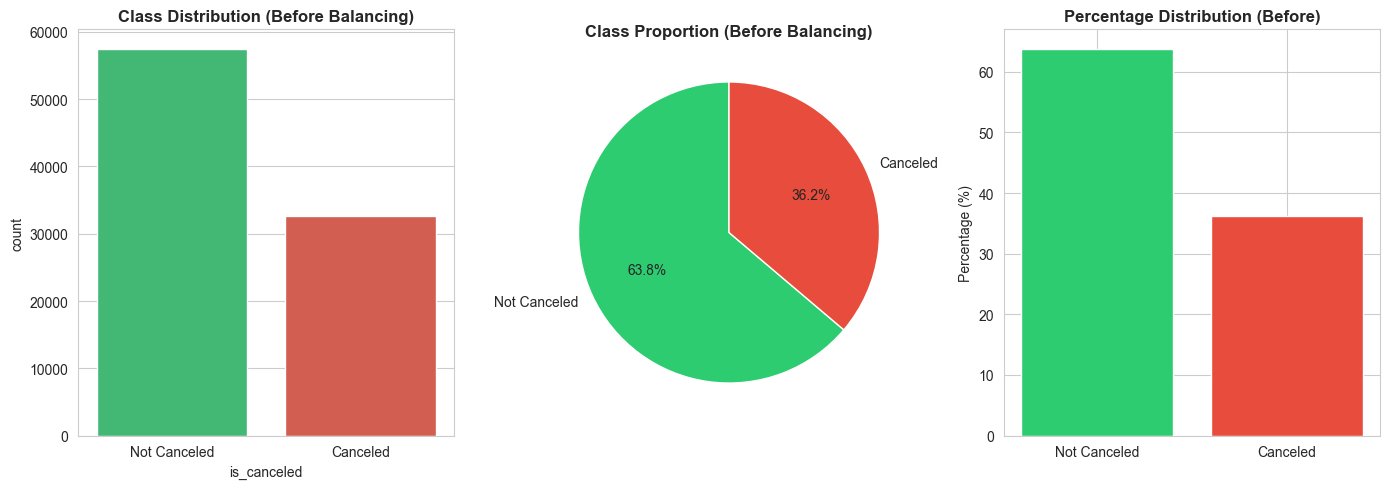


STEP 4: APPLYING CLASS BALANCING (TRAINING SET ONLY)
----------------------------------------------------------------------

Before Balancing:
  Majority class (0): 57,488
  Minority class (1): 32,605

After Balancing:
  Class 0: 57,488 (50.00%)
  Class 1: 57,488 (50.00%)
✓ Classes are now PERFECTLY BALANCED (50/50)

PART C COMPLETED SUCCESSFULLY
KEY POINT:
The dataset was split into training and test sets before class balancing.
Oversampling was applied ONLY on the training set to prevent data leakage.
The test set remains untouched for fair model evaluation.
Variables Created:
  - X_balanced: (114976, 259)
  - y_balanced: (114976,)
  - X_test (untouched): (22524, 259)
  - y_test (untouched): (22524,)



In [8]:
# PART C: DATA BALANCE CHECKING & CLASS BALANCING
print("=" * 70)
print("PART C: DATA BALANCE CHECKING & CLASS BALANCING")
print("=" * 70)
print("\n")

from sklearn.utils import resample
from sklearn.model_selection import train_test_split



# STEP 1: TRAIN–TEST SPLIT (BEFORE BALANCING)
print("STEP 1: TRAIN–TEST SPLITTING (BEFORE BALANCING)")
print("-" * 70)

X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTraining Set Shape:")
print(f"  - X_train: {X_train.shape}")
print(f"  - y_train: {y_train.shape}")

print(f"\nTest Set Shape (UNTOUCHED):")
print(f"  - X_test: {X_test.shape}")
print(f"  - y_test: {y_test.shape}")


# STEP 2: ANALYZE CLASS DISTRIBUTION (TRAINING DATA ONLY)
print("\n" + "=" * 70)
print("STEP 2: ANALYZING CLASS DISTRIBUTION (TRAINING SET)")
print("-" * 70)

class_counts = y_train.value_counts().sort_index()
class_percentages = y_train.value_counts(normalize=True).sort_index() * 100

print(f"\nClass Distribution (Before Balancing):")
print(f"  Class 0 (Not Canceled): {class_counts[0]:,} ({class_percentages[0]:.2f}%)")
print(f"  Class 1 (Canceled): {class_counts[1]:,} ({class_percentages[1]:.2f}%)")

imbalance_ratio = class_counts[0] / class_counts[1]
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1 (Class 0 to Class 1)")

if imbalance_ratio > 1.5:
    print("SIGNIFICANT IMBALANCE DETECTED - Balancing is required")
else:
    print("Classes are relatively balanced")

# STEP 3: VISUALIZE INITIAL DISTRIBUTION (TRAINING DATA)
print("\n" + "=" * 70)
print("STEP 3: VISUALIZING INITIAL DISTRIBUTION (TRAINING DATA)")
print("-" * 70)

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
sns.countplot(
    data=pd.DataFrame({'is_canceled': y_train}),
    x='is_canceled',
    hue='is_canceled',
    dodge=False,
    palette=['#2ecc71', '#e74c3c'],
    legend=False
)
plt.title('Class Distribution (Before Balancing)', fontweight='bold')
plt.xticks([0, 1], ['Not Canceled', 'Canceled'])

plt.subplot(1, 3, 2)
plt.pie(
    class_counts.values,
    labels=['Not Canceled', 'Canceled'],
    autopct='%1.1f%%',
    colors=['#2ecc71', '#e74c3c'],
    startangle=90
)
plt.title('Class Proportion (Before Balancing)', fontweight='bold')

plt.subplot(1, 3, 3)
plt.bar(
    ['Not Canceled', 'Canceled'],
    class_percentages.values,
    color=['#2ecc71', '#e74c3c']
)
plt.title('Percentage Distribution (Before)', fontweight='bold')
plt.ylabel('Percentage (%)')

plt.tight_layout()
plt.show()


# STEP 4: APPLY CLASS BALANCING (TRAINING DATA ONLY)
print("\n" + "=" * 70)
print("STEP 4: APPLYING CLASS BALANCING (TRAINING SET ONLY)")
print("-" * 70)

df_train = pd.concat([X_train, y_train], axis=1)

majority_class = df_train[df_train['is_canceled'] == 0]
minority_class = df_train[df_train['is_canceled'] == 1]

print(f"\nBefore Balancing:")
print(f"  Majority class (0): {len(majority_class):,}")
print(f"  Minority class (1): {len(minority_class):,}")

minority_upsampled = resample(
    minority_class,
    replace=True,
    n_samples=len(majority_class),
    random_state=42
)

df_balanced = pd.concat([majority_class, minority_upsampled], axis=0)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X_balanced = df_balanced.drop('is_canceled', axis=1)
y_balanced = df_balanced['is_canceled']

balanced_counts = y_balanced.value_counts().sort_index()
balanced_percentages = y_balanced.value_counts(normalize=True).sort_index() * 100

print(f"\nAfter Balancing:")
print(f"  Class 0: {balanced_counts[0]:,} ({balanced_percentages[0]:.2f}%)")
print(f"  Class 1: {balanced_counts[1]:,} ({balanced_percentages[1]:.2f}%)")
print("✓ Classes are now PERFECTLY BALANCED (50/50)")

# STEP 5: SUMMARY
print("\n" + "=" * 70)
print("PART C COMPLETED SUCCESSFULLY")
print("=" * 70)

print("KEY POINT:")
print("The dataset was split into training and test sets before class balancing.")
print("Oversampling was applied ONLY on the training set to prevent data leakage.")
print("The test set remains untouched for fair model evaluation.")

print("Variables Created:")
print(f"  - X_balanced: {X_balanced.shape}")
print(f"  - y_balanced: {y_balanced.shape}")
print(f"  - X_test (untouched): {X_test.shape}")
print(f"  - y_test (untouched): {y_test.shape}")

print("\n" + "=" * 70)


In [9]:
# PART D: FEATURE ENGINEERING 

import pandas as pd
import numpy as np

print("=" * 70)
print("PART D: FEATURE ENGINEERING")
print("=" * 70)
print("\n")
# 1. DATE FEATURE EXTRACTION (OPTIONAL & SAFE)
month_available = False

if 'arrival_date_month' in df.columns:
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    df['arrival_date_month_num'] = df['arrival_date_month'].map(month_map)
    month_available = True
    print("✓ arrival_date_month mapped to numeric")

elif 'arrival_date_month_num' in df.columns:
    month_available = True
    print("✓ arrival_date_month_num already exists")

else:
    print("arrival month info not available — skipping month-based features")


# Build arrival_date only if all components exist
date_cols = ['arrival_date_year', 'arrival_date_month_num', 'arrival_date_day_of_month']

if month_available and all(col in df.columns for col in date_cols):
    df['arrival_date'] = pd.to_datetime(df[date_cols], errors='coerce')

    df['arrival_weekday'] = df['arrival_date'].dt.weekday
    df['arrival_week'] = df['arrival_date'].dt.isocalendar().week.astype(int)
    df['arrival_season'] = df['arrival_date_month_num'] % 12 // 3 + 1

    print("✓ Date-based features created")
else:
    print("Skipping arrival_date feature creation")


# 2. CREATE NEW FEATURES
df['total_stay'] = (
    df.get('stays_in_weekend_nights', 0) +
    df.get('stays_in_week_nights', 0)
)

df['total_guests'] = (
    df.get('adults', 0) +
    df.get('children', 0) +
    df.get('babies', 0)
)

df['is_family'] = ((df['children'] > 0) | (df['babies'] > 0)).astype(int)

df['adr_per_person'] = df['adr'] / (df['total_guests'] + 1)

df['long_lead_time'] = (df['lead_time'] > df['lead_time'].median()).astype(int)

print("✓ Custom behavioral features created")


# 3. DROP IRRELEVANT / LEAKAGE FEATURES (SAFE)

drop_cols = [
    'arrival_date',
    'arrival_date_month',
    'reservation_status_date',
    'company',
    'agent',
    'country'
]

df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

print("Irrelevant / leakage columns removed")

# 3b. DROP HIGHLY CORRELATED FEATURES

# Compute correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle (since correlation matrix is symmetric)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Threshold for high correlation (e.g., 0.85)
threshold = 0.85

# Find columns with correlation above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

if to_drop:
    df.drop(columns=to_drop, inplace=True)
    print(f"✓ Dropped highly correlated features: {to_drop}")
else:
    print("✓ No highly correlated features to drop")


# 4. FINAL CHECK

print("\nFeature Engineering Completed Successfully")
print(f"Final Dataset Shape: {df.shape}")

print("\nEngineered Features Present:")
engineered_features = [
    'arrival_weekday',
    'arrival_week',
    'arrival_season',
    'total_stay',
    'total_guests',
    'is_family',
    'adr_per_person',
    'long_lead_time'
]

for f in engineered_features:
    if f in df.columns:
        print(f"  - {f}")

print("=" * 70)


PART D: FEATURE ENGINEERING


arrival month info not available — skipping month-based features
Skipping arrival_date feature creation
✓ Custom behavioral features created
Irrelevant / leakage columns removed
✓ Dropped highly correlated features: ['distribution_channel_Direct', 'assigned_room_type_H', 'assigned_room_type_P', 'reservation_status_Check-Out', 'total_stay', 'is_family']

Feature Engineering Completed Successfully
Final Dataset Shape: (112617, 257)

Engineered Features Present:
  - total_guests
  - adr_per_person
  - long_lead_time


## Part E — Feature Selection (Genetic Algorithm)

is_canceled                   1.000000
deposit_type                  0.456417
country_PRT                   0.320615
lead_time                     0.288038
market_segment_Groups         0.205461
distribution_channel_TA/TO    0.170479
previous_cancellations        0.113101
adr                           0.073889
adults                        0.060348
days_in_waiting_list          0.057564
Name: is_canceled, dtype: float64
PART D-E: FEATURE SELECTION USING GENETIC ALGORITHM

Total Features Before GA: 257


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.733916	0.0189838  	0.751877   	0.68202    
1  	15    	0.751094	0.0041466  	0.762745   	0.748423   
2  	14    	0.75325 	0.00447498 	0.762745   	0.748724   
3  	17    	0.755214	0.00399118 	0.762745   	0.749967   
4  	15    	0.761696	0.00678684 	0.7738     	0.751877   
5  	15    	0.765068	0.00605793 	0.7738     	0.75787    

Number of features selected by GA: 128
Selected Features: ['arrival_date_week_number', 'stays_in_weekend_nights', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'deposit_type', 'company', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_time_seconds', 'arrival_date_month_December', 'arrival_date_month_June', 'arrival_date_month_March', 'arrival_date_month_May', 'arrival_date_month_October', 'meal_FB', 'meal_SC', 'meal_Undefined', 'country_AGO', 'country_ALB', 'country_ARM', 'country_ATF', 'country_AUS

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn_genetic/plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


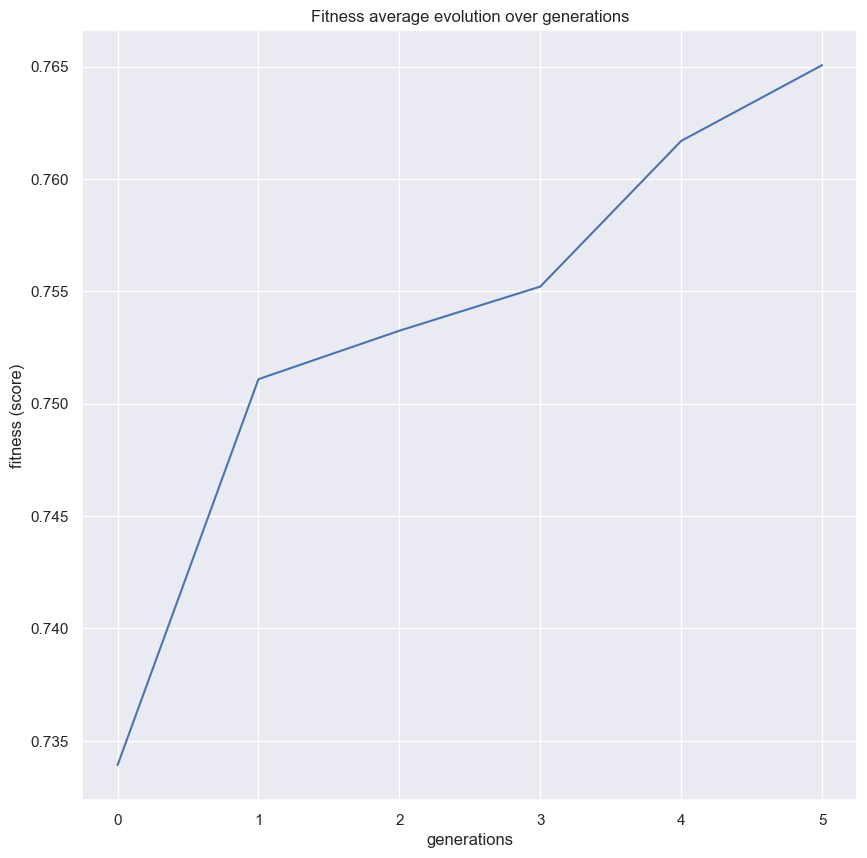

In [10]:
# Remove leakage columns (including one-hot encoded)
leakage_cols = [col for col in X.columns if col.startswith('reservation_status')]
X = X.drop(columns=leakage_cols)

# Correlation sanity check
corr = pd.concat([X, y], axis=1).corr(numeric_only=True)['is_canceled']
print(corr.sort_values(ascending=False).head(10))

# drop all features that leak the target
leakage_like = corr[abs(corr) > 0.9].index.drop('is_canceled')

X = X.drop(columns=leakage_like, errors='ignore')




# FEATURE SELECTION USING GENETIC ALGORITHM

print("="*70)
print("PART D-E: FEATURE SELECTION USING GENETIC ALGORITHM")
print("="*70, "\n")

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn_genetic import GAFeatureSelectionCV
from sklearn_genetic.plots import plot_fitness_evolution

# ------------------------------
# 1. Total features before GA
# ------------------------------
total_features = X.shape[1]
print(f"Total Features Before GA: {total_features}")

# ------------------------------
# 2. Define the model for GA
# ------------------------------
model = LogisticRegression(max_iter=500, solver='liblinear')  # fast and stable

# ------------------------------
# 3. GA Feature Selection
# ------------------------------
ga_selector = GAFeatureSelectionCV(
    estimator=model,
    cv=5,
    scoring="accuracy",
    population_size=10,   # smaller population to speed up
    generations=5,        # fewer generations
    n_jobs=-1,            # parallelize across cores
    verbose=True,
    keep_top_k=1,
    crossover_probability=0.5,
    mutation_probability=0.2,
    tournament_size=3,
    elitism=True
)

# Fit GA on the ORIGINAL dataset
ga_selector.fit(X, y)

# ------------------------------
# 4. Selected features and results
# ------------------------------
selected_features = X.columns[ga_selector.support_]
print(f"\nNumber of features selected by GA: {len(selected_features)}")
print("Selected Features:", list(selected_features))

# Obtain best score safely (some versions do not expose `best_score_`)
if hasattr(ga_selector, 'best_score_'):
    best_score = ga_selector.best_score_
elif hasattr(ga_selector, 'best_score'):
    best_score = ga_selector.best_score
else:
    # Fallback: evaluate the selected feature subset with cross_val_score
    if len(selected_features) > 0:
        try:
            best_score = cross_val_score(model, X[selected_features], y, cv=5, scoring='accuracy', n_jobs=-1).mean()
        except Exception as e:
            best_score = None
            print(f"Warning: could not compute fallback best_score: {e}")
    else:
        best_score = None

if best_score is not None:
    print(f"\nBest cross-validated accuracy achieved by GA: {best_score:.4f}")
else:
    print("\nBest score not available from GA selector and fallback evaluation failed.")

# Plot fitness evolution (guarded)
try:
    plot_fitness_evolution(ga_selector)
except Exception as e:
    print(f"Could not plot fitness evolution: {e}")


## Part F — Model Evaluation

In [11]:
# ================================
# PART F: PERFORMANCE EVALUATION (GA-selected Features)
# ================================

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd

# ------------------------------------------------------------
# Prepare data using GA-selected features
# ------------------------------------------------------------
X_train_sel = X_train[selected_features].copy()  # GA-selected features
X_test_sel  = X_test[selected_features].copy()

# -----------------------------
# Create validation set (20% of training set)
# -----------------------------
X_train_sel, X_val_sel, y_train_sub, y_val = train_test_split(
    X_train_sel, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_sel = imputer.fit_transform(X_train_sel)
X_val_sel   = imputer.transform(X_val_sel)
X_test_sel  = imputer.transform(X_test_sel)

# ------------------------------------------------------------
# Utility function to train, tune, and evaluate a model
# ------------------------------------------------------------
def evaluate_model(model_class, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    best_model = None
    best_params = None
    best_acc = 0

    # Hyperparameter tuning using validation set
    for params in param_grid:
        model = model_class(**params) if params else model_class()
        model.fit(X_train, y_train)
        val_pred = model.predict(X_val)
        acc = accuracy_score(y_val, val_pred)
        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_params = params

    # Final evaluation on test set
    y_pred = best_model.predict(X_test)
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'conf_matrix': confusion_matrix(y_test, y_pred)
    }
    return metrics

# ------------------------------------------------------------
# Define hyperparameters to tune
# ------------------------------------------------------------
knn_params = [{'n_neighbors': k} for k in [3, 5, 7, 9]]
tree_params = [{'max_depth': d} for d in [3, 5, 7, 9, None]]
mlp_params = [{'hidden_layer_sizes': h} for h in [(50,), (100,), (50, 50)]]

# ------------------------------------------------------------
# Evaluate models
# ------------------------------------------------------------
results = []
results.append(evaluate_model(KNeighborsClassifier, knn_params, X_train_sel, y_train_sub, X_val_sel, y_val, X_test_sel, y_test, "KNN"))
results.append(evaluate_model(DecisionTreeClassifier, tree_params, X_train_sel, y_train_sub, X_val_sel, y_val, X_test_sel, y_test, "Decision Tree"))
results.append(evaluate_model(MLPClassifier, mlp_params, X_train_sel, y_train_sub, X_val_sel, y_val, X_test_sel, y_test, "MLP"))

# ------------------------------------------------------------
# Display results
# ------------------------------------------------------------
performance_df = pd.DataFrame(results)
performance_df = performance_df.sort_values(by='f1', ascending=False).reset_index(drop=True)

print("\n================== PERFORMANCE SUMMARY ==================\n")
print(performance_df[['model', 'accuracy', 'precision', 'recall', 'f1']])

# Display confusion matrices
for res in results:
    print(f"\nConfusion Matrix for {res['model']}:\n{res['conf_matrix']}")

# Identify best model
best_model_name = performance_df.iloc[0]['model']
best_model_f1   = performance_df.iloc[0]['f1']
print(f"\nBest model by F1 score: {best_model_name} (F1={best_model_f1:.4f})")



================== PERFORMANCE SUMMARY ==================

           model  accuracy  precision    recall        f1
0  Decision Tree  0.794752   0.770968  0.615753  0.684674
1            MLP  0.793154   0.780527  0.596000  0.675896
2            KNN  0.601314   0.417709  0.258128  0.319078

Confusion Matrix for KNN:
[[11440  2933]
 [ 6047  2104]]

Confusion Matrix for Decision Tree:
[[12882  1491]
 [ 3132  5019]]

Confusion Matrix for MLP:
[[13007  1366]
 [ 3293  4858]]

Best model by F1 score: Decision Tree (F1=0.6847)
